# 프로젝트 : SRGAN 활용하기

## 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기

## 평가 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준
1. SRGAN을 이용해 고해상도의 이미지를 생성하였다.: SRGAN을 통해 생성된 이미지를 제출하였다.
2. 다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN생성본, interpolation생성본을 비교분석하였다. : 이미지의 특성과 super resolution 방법을 관련지어 생성 결과를 체계적으로 분석하였다.
3. 저해상도 gif 동영상을 고해상도 동영상으로 성공적으로 변환하였다. : 저해상도 원본 gif와 생성된 고해상도 gif의 해상도 차이가 시각적으로 확인 가능하다.


## 프로젝트 1-1. 높은 해상도 사진

### 1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds 
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras import Input, Model
from tensorflow.keras import losses, metrics, optimizers
from tensorflow.python.keras import applications
from skimage import data
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from PIL import Image
from glob import glob
import warnings
warnings.filterwarnings("ignore")

In [49]:
hr_image = Image.open('./HR.jpg')

In [50]:
hr_image = np.array(hr_image)

In [51]:
hr_image.shape

(768, 1024, 3)

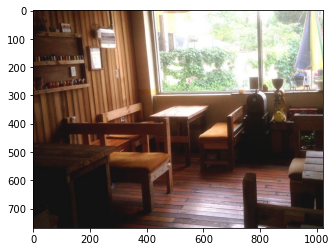

In [52]:
plt.figure(figsize=(6,4))
plt.imshow(hr_image)

### 2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. 
cv2.resize()를 사용해 봅시다.

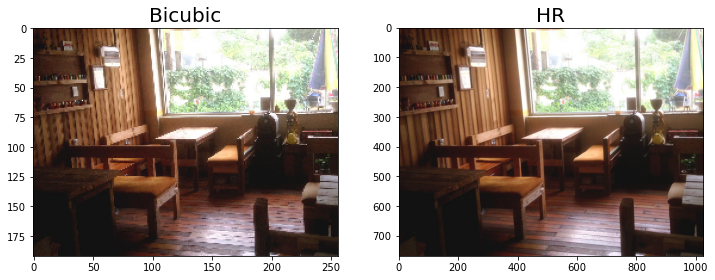

In [58]:
bicubic_image = cv2.resize(
    hr_image, 
    dsize=(256, 192), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

lr_image = bicubic_image
images = [lr_image, hr_image]

titles = ["Bicubic", "HR"]

plt.figure(figsize=(12,8))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)    

### 3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 
이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.

In [59]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [60]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

In [61]:
srgan_hr = apply_srgan(lr_image)

In [62]:
srgan_hr.shape

(768, 1024, 3)

### 4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 
마찬가지로 cv2.resize()를 사용해 봅시다.

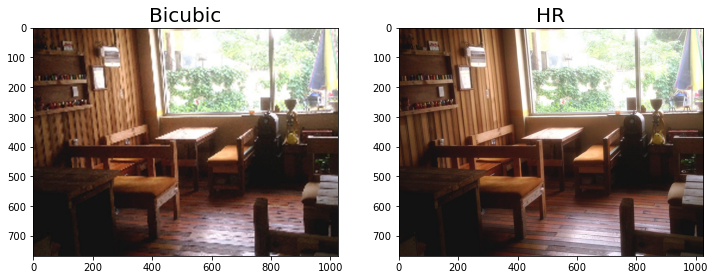

In [74]:
bicubic_image = cv2.resize(
    lr_image, 
    dsize=(1025, 768), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

hlr_image = bicubic_image
images = [hlr_image, hr_image]
titles = ["Bicubic", "HR"]

plt.figure(figsize=(12,8))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

### 5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화 합니다. 
각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.

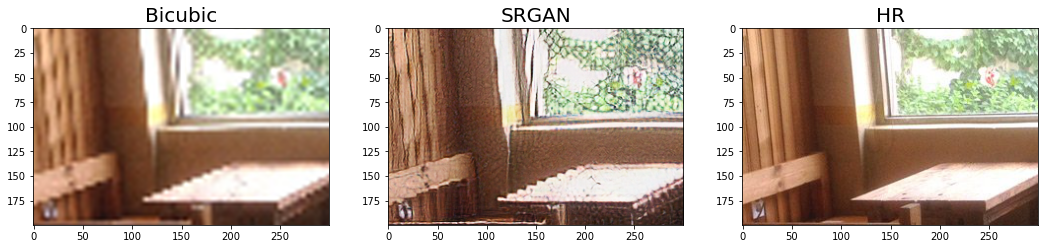

In [79]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(200,300), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(hlr_image, left_top, 200, 300)
    img2 = crop(srgan_hr , left_top, 200, 300)
    img3 = crop(hr_image, left_top, 200, 300)
    images.extend([img1, img2, img3])

titles = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(18,18))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

### 6. 왜 이러한 결과가 출력되었는지 설명해 봅시다. 
선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 나온 결과에 대해서 해석해 봅시다. 

#### * SRGAN 결과의 경우 매우 창문 밖의 나뭇잎이 선명하게 표현되었지만, 연꽃 모양으로 이상하게 선명하게 표현됨을 확인할 수 있습니다. 
#### * 이는 Generator가 고해상도 이미지를 생성하는 과정에서 Discriminator를 속이기 위해 이미지를 진짜 같이 선명하게 만들도록 학습 되었기 때문입니다. 

## 프로젝트 1-2. 낮은 해상도 사진

### 1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.

In [50]:
lr_image = Image.open('./download.jpeg')

In [51]:
lr_image = np.array(lr_image)

In [52]:
lr_image.shape

(227, 222, 3)

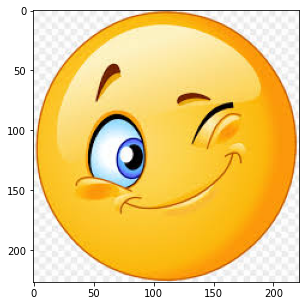

In [53]:
plt.figure(figsize=(5,5))
plt.imshow(lr_image)

### 2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 
이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.

In [54]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [55]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

In [56]:
srgan_hr = apply_srgan(lr_image)

In [57]:
srgan_hr.shape

(908, 888, 3)

### 3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 
cv2.resize()를 사용해 봅시다.


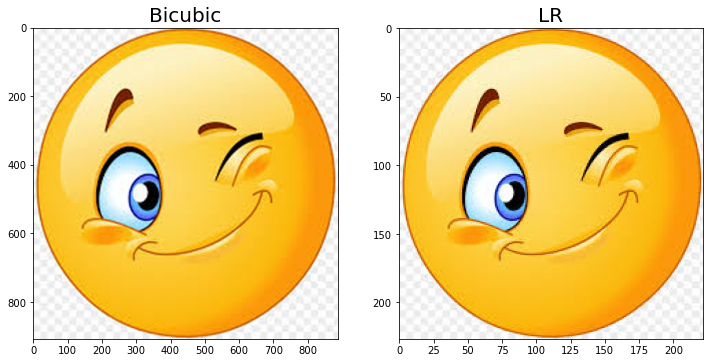

In [58]:
bicubic_image = cv2.resize(
    lr_image, 
    dsize=(888, 908), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

hlr_image = bicubic_image
images = [hlr_image, lr_image]
titles = ["Bicubic", "LR"]

plt.figure(figsize=(12,12))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

### 4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화 합니다. 
각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.

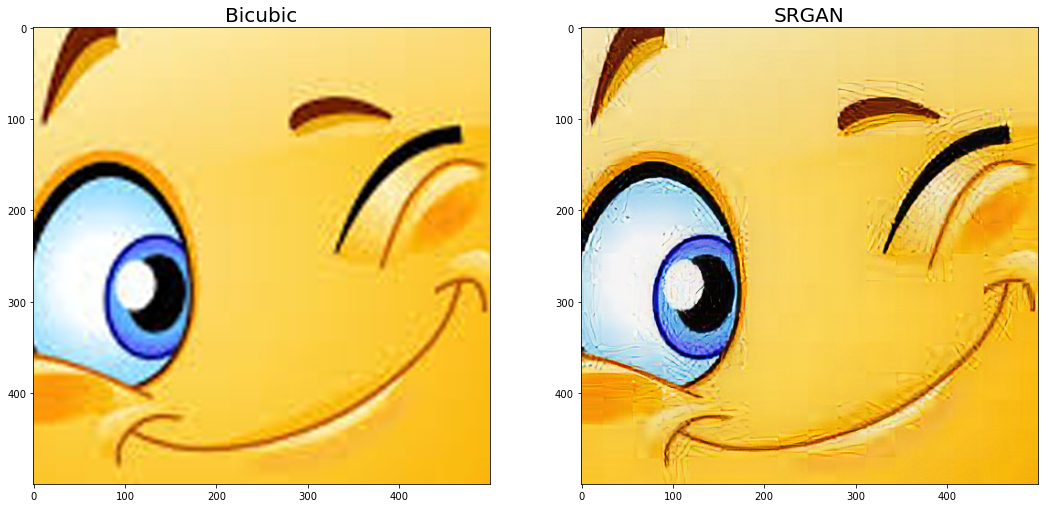

In [67]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=50):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(200,200), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(hlr_image, left_top, 500, 500)
    img2 = crop(srgan_hr , left_top, 500, 500)
    images.extend([img1, img2])

titles = ["Bicubic", "SRGAN"]

plt.figure(figsize=(18,18))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

### 5. 왜 이러한 결과가 출력되었는지 설명해 봅시다.
선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 나온 결과에 대해서 해석해 봅시다. 

#### * SRGAN 결과는 눈 주변의 선이 매우 또렷하게 표현되었지만, 뭉게져야 할 작은 선들이 지나치게 선명하게 표현되어 주름처럼 표현됨을 확인할 수 있습니다. 
#### * 이는 Generator가 고해상도 이미지를 생성하는 과정에서 Discriminator를 속이기 위해 이미지를 진짜 같이 선명하게 만들도록 학습 되었기 때문입니다. 